# Visualize Streets Clustered By Street Address Arrangment

We want to visualize the cluster assignments for streets. See [ARS.ipynb](./ARS.ipynb) for details about the clustering method.

We need to figure out the streets within a graph's bound by doing the following:

1. Get the plot limits.
2. Make an overpass request to get the streets within the limit.
3. Get the polylines for those streets.
4. Plot the polylines colored with their cluster assignments.

In [1]:
import glob
import json
import urllib
import ntpath
import requests
import operator
import polyline
import functools
import numpy as np
import osmnx as ox
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from geopy import distance
from itertools import groupby, combinations
from IPython.display import Image
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.cluster import MiniBatchKMeans
from shapely.geometry import Polygon, LineString

In [2]:
ox.config(log_console=True, use_cache=True)

mpl.rcParams['figure.dpi'] = 300

sns.set(color_codes=True)
sns.set(rc={'figure.figsize':(12.5,9.7)})

Load clustered streets created by [ARS.ipynb](./ARS.ipynb).

In [3]:
clustered_streets = pd.read_pickle('./data/tmp/ngram_clusters.dat')

In [4]:
def fetch_streets_within_bbox(min_lat, min_lon, max_lat, max_lon):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = f"""
    [out:json];
    (
     way({min_lat},{min_lon},{max_lat},{max_lon})[highway][name];
    );
    out center;
    """
    response = requests.get(overpass_url, 
                            params={'data': overpass_query})
    return response.json()

In [5]:
def get_streets_names_within_axis(ax):
    """Fetches the names of streets that lie within the limits of an matplotlib axis."""
    min_lat, max_lat = ax.get_ylim()
    min_lon, max_lon = ax.get_xlim()
    names = []
    data = fetch_streets_within_bbox(min_lat, min_lon, max_lat, max_lon)
    for i in data['elements']:
        names.append(i['tags']['name'])
        
    return names

In [6]:
def get_polylines():
    with open('./data/berlin.polylines', 'r') as f:
        polylines = {}
        lines = f.read().splitlines()
        for l in lines:
            val, key = l.split('\0')
            existing_line = polylines[key] if key in polylines else []
            existing_line.append(val)
            polylines[key] = existing_line

        return polylines
    
@functools.lru_cache(maxsize=100000)
def decode_polyline(line):
    return polyline.decode(line, 6)

In [7]:
polylines = get_polylines()

In [8]:
polylines['Arendsweg']

['k{mecBwaiwX_Hn@}@@}ABkACah@gAaEIiORy^Uw`@t@oQHgKJsg@rBkPLaw@vByx@dAoz@xB']

In [9]:
decode_polyline(polylines['Arendsweg'][0])

[(52.534726, 13.50558),
 (52.53487, 13.505556),
 (52.534901, 13.505555),
 (52.534948, 13.505553),
 (52.534986, 13.505555),
 (52.535643, 13.505591),
 (52.53574, 13.505596),
 (52.536001, 13.505586),
 (52.53651, 13.505597),
 (52.53705, 13.50557),
 (52.537346, 13.505565),
 (52.537542, 13.505559),
 (52.538192, 13.505501),
 (52.53847, 13.505494),
 (52.539367, 13.505434),
 (52.540292, 13.505399),
 (52.541244, 13.505338)]

#### Plot a Polyline

In [10]:
# x & y in these plots are reversed compared to a normal street plot.
def plot_coords(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, 'o', color='#DC143C', zorder=1)

def plot_bounds(ax, ob):
    x, y = zip(*list((p.x, p.y) for p in ob.boundary))
    ax.plot(x, y, 'o', color='#DC143C', zorder=1)

def plot_line(ax, ob):
    x, y = ob.xy
    ax.plot(x, y, color='#DC143C', alpha=0.7, linewidth=3, solid_capstyle='round', zorder=2)

Text(0.5, 1.0, 'Arendsweg')

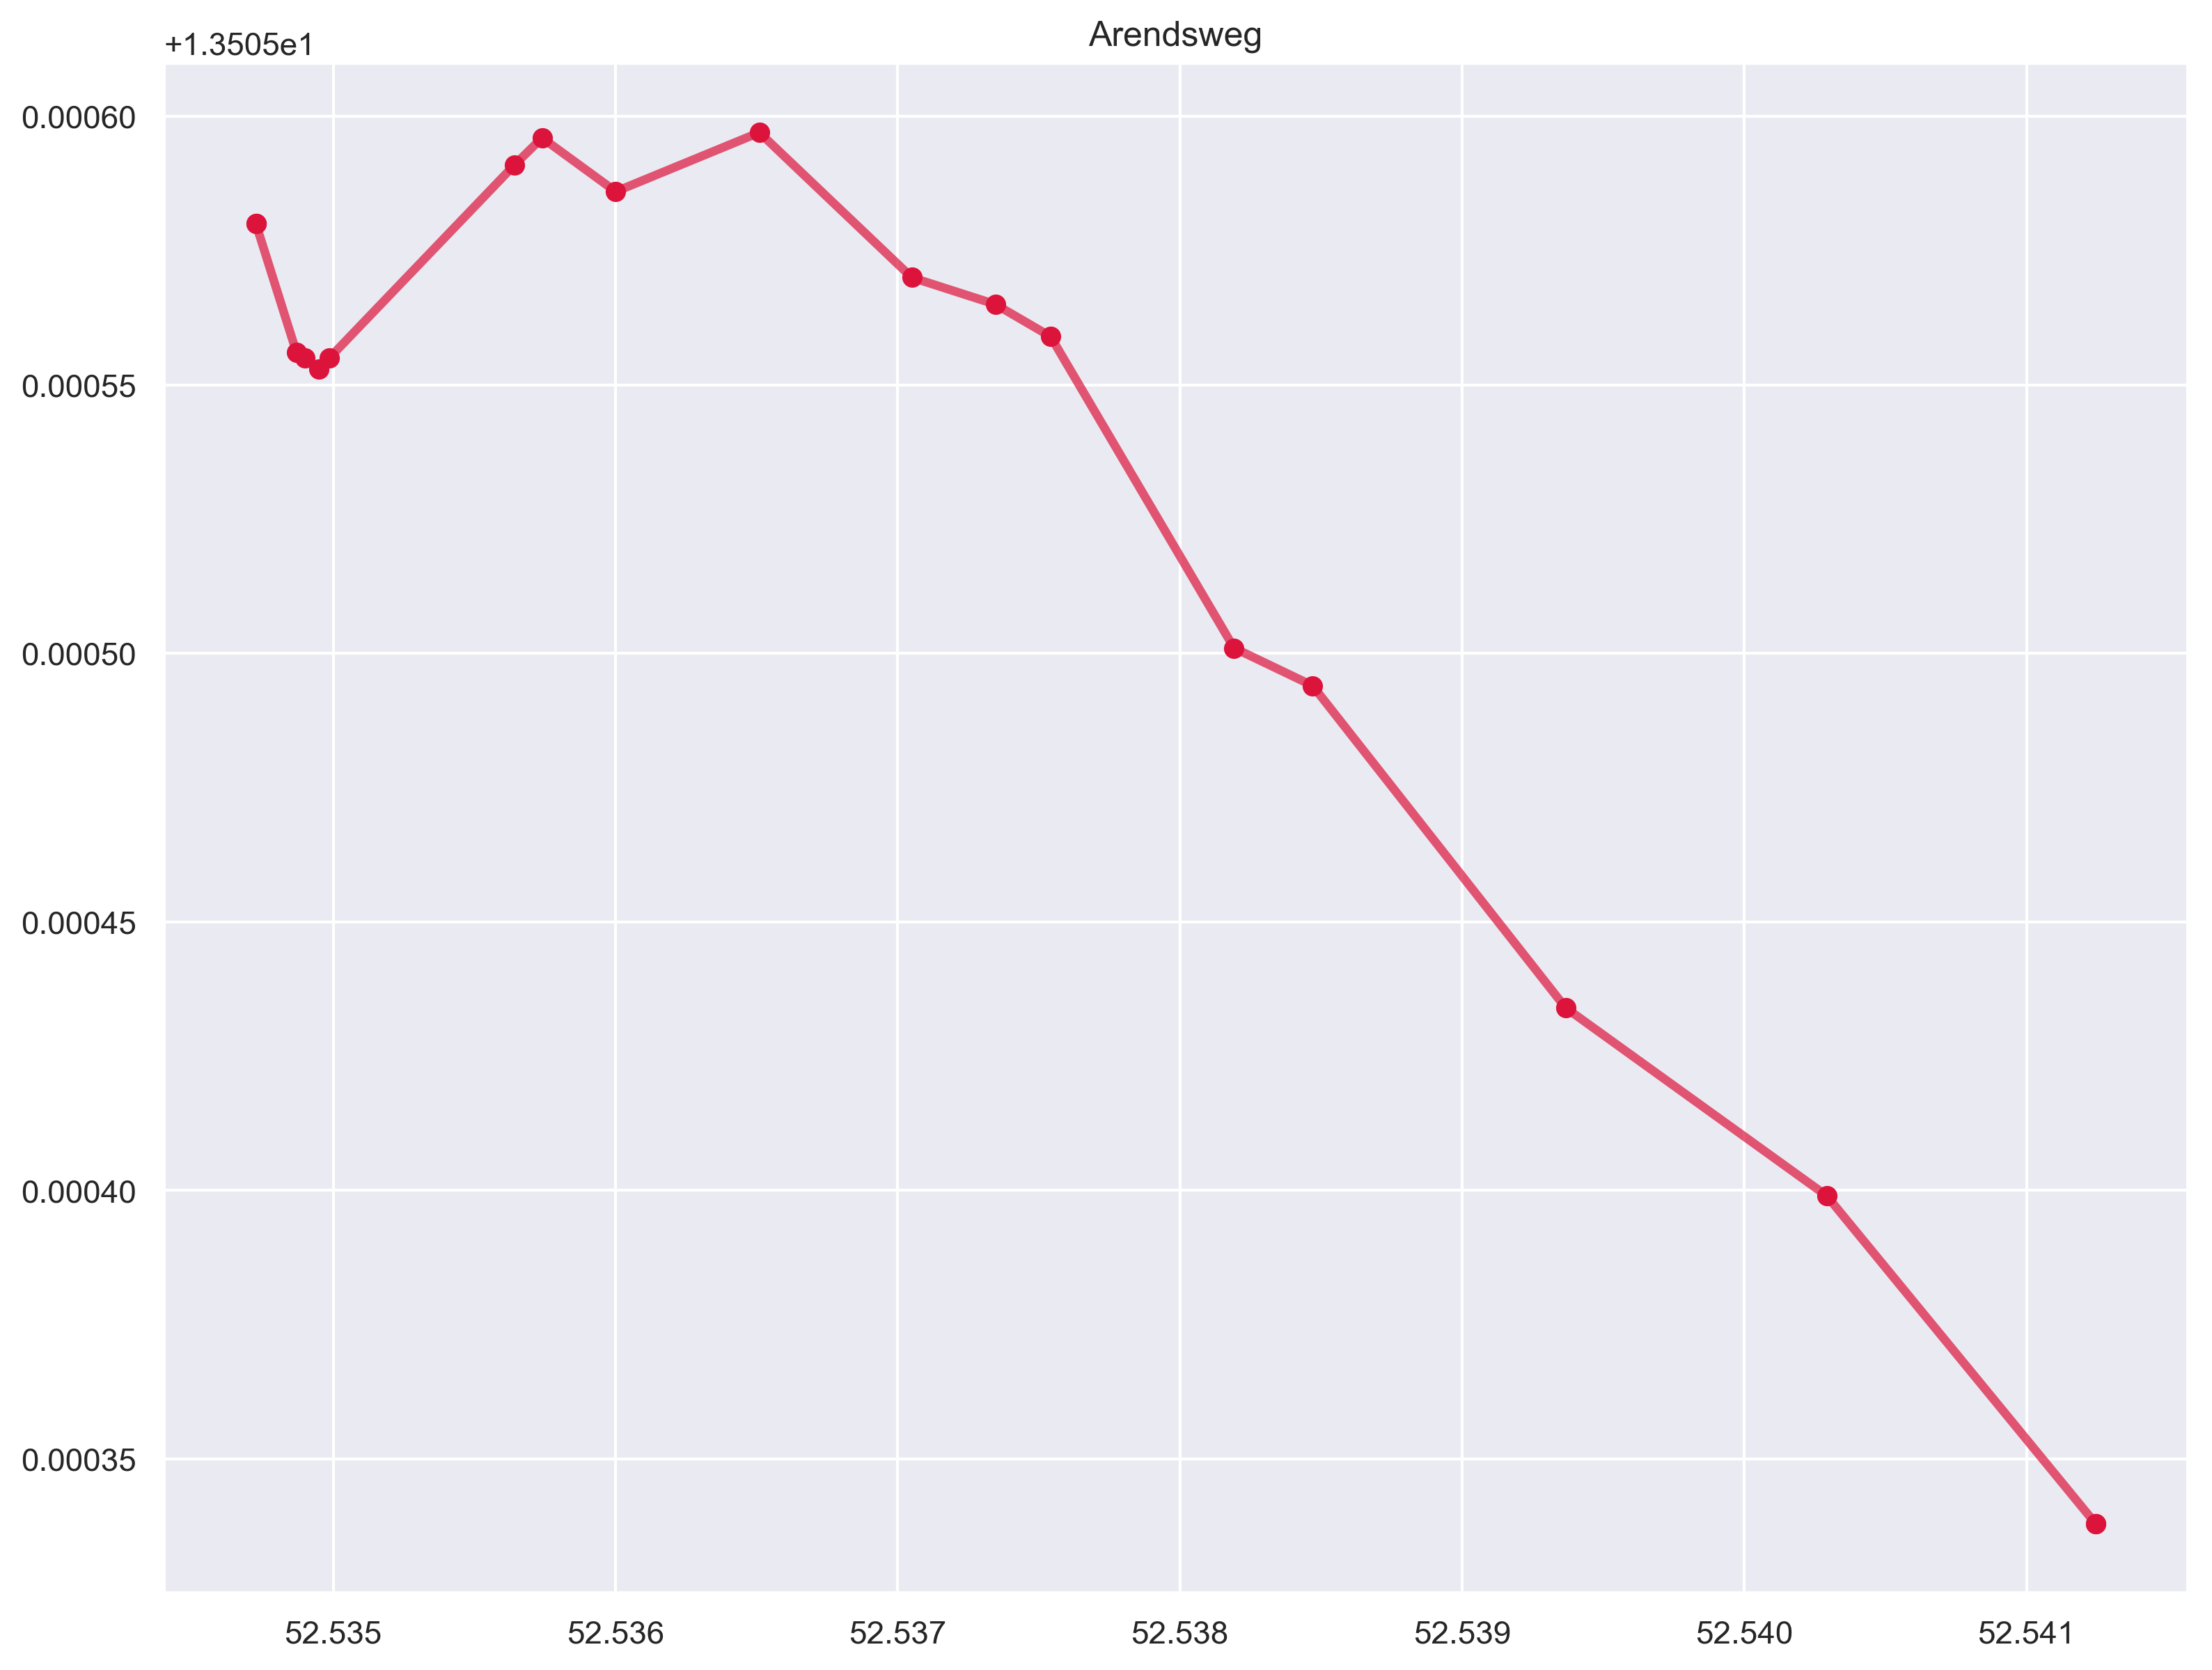

In [11]:
ax = plt.gca()
line = LineString(decode_polyline(polylines['Arendsweg'][0]))

plot_coords(ax, line)
plot_bounds(ax, line)
plot_line(ax, line)

ax.set_title('Arendsweg')

#### Plot Cluster Assigned Streets

In [12]:
def plot_streets_within_axis(ax):
    str_names = list(set(get_streets_names_within_axis(ax)))
    colors = ['#ff8100', '#07d2cd', '#fff400', '#ff0000', '#06adff']

    for s in str_names:
        line = polylines.get(s)
        clust_str = clustered_streets[clustered_streets['street'] == s]
        
        if not line or len(clust_str) == 0:
            continue
        
        for l in line:
            line_str = LineString(decode_polyline(l))
            color = colors[clust_str['cluster_assignment'].values[0]]
            x, y = line_str.xy
            ax.plot(y, x, color=color, alpha=0.7, linewidth=3, solid_capstyle='round', gid=s)

<IPython.core.display.Javascript object>


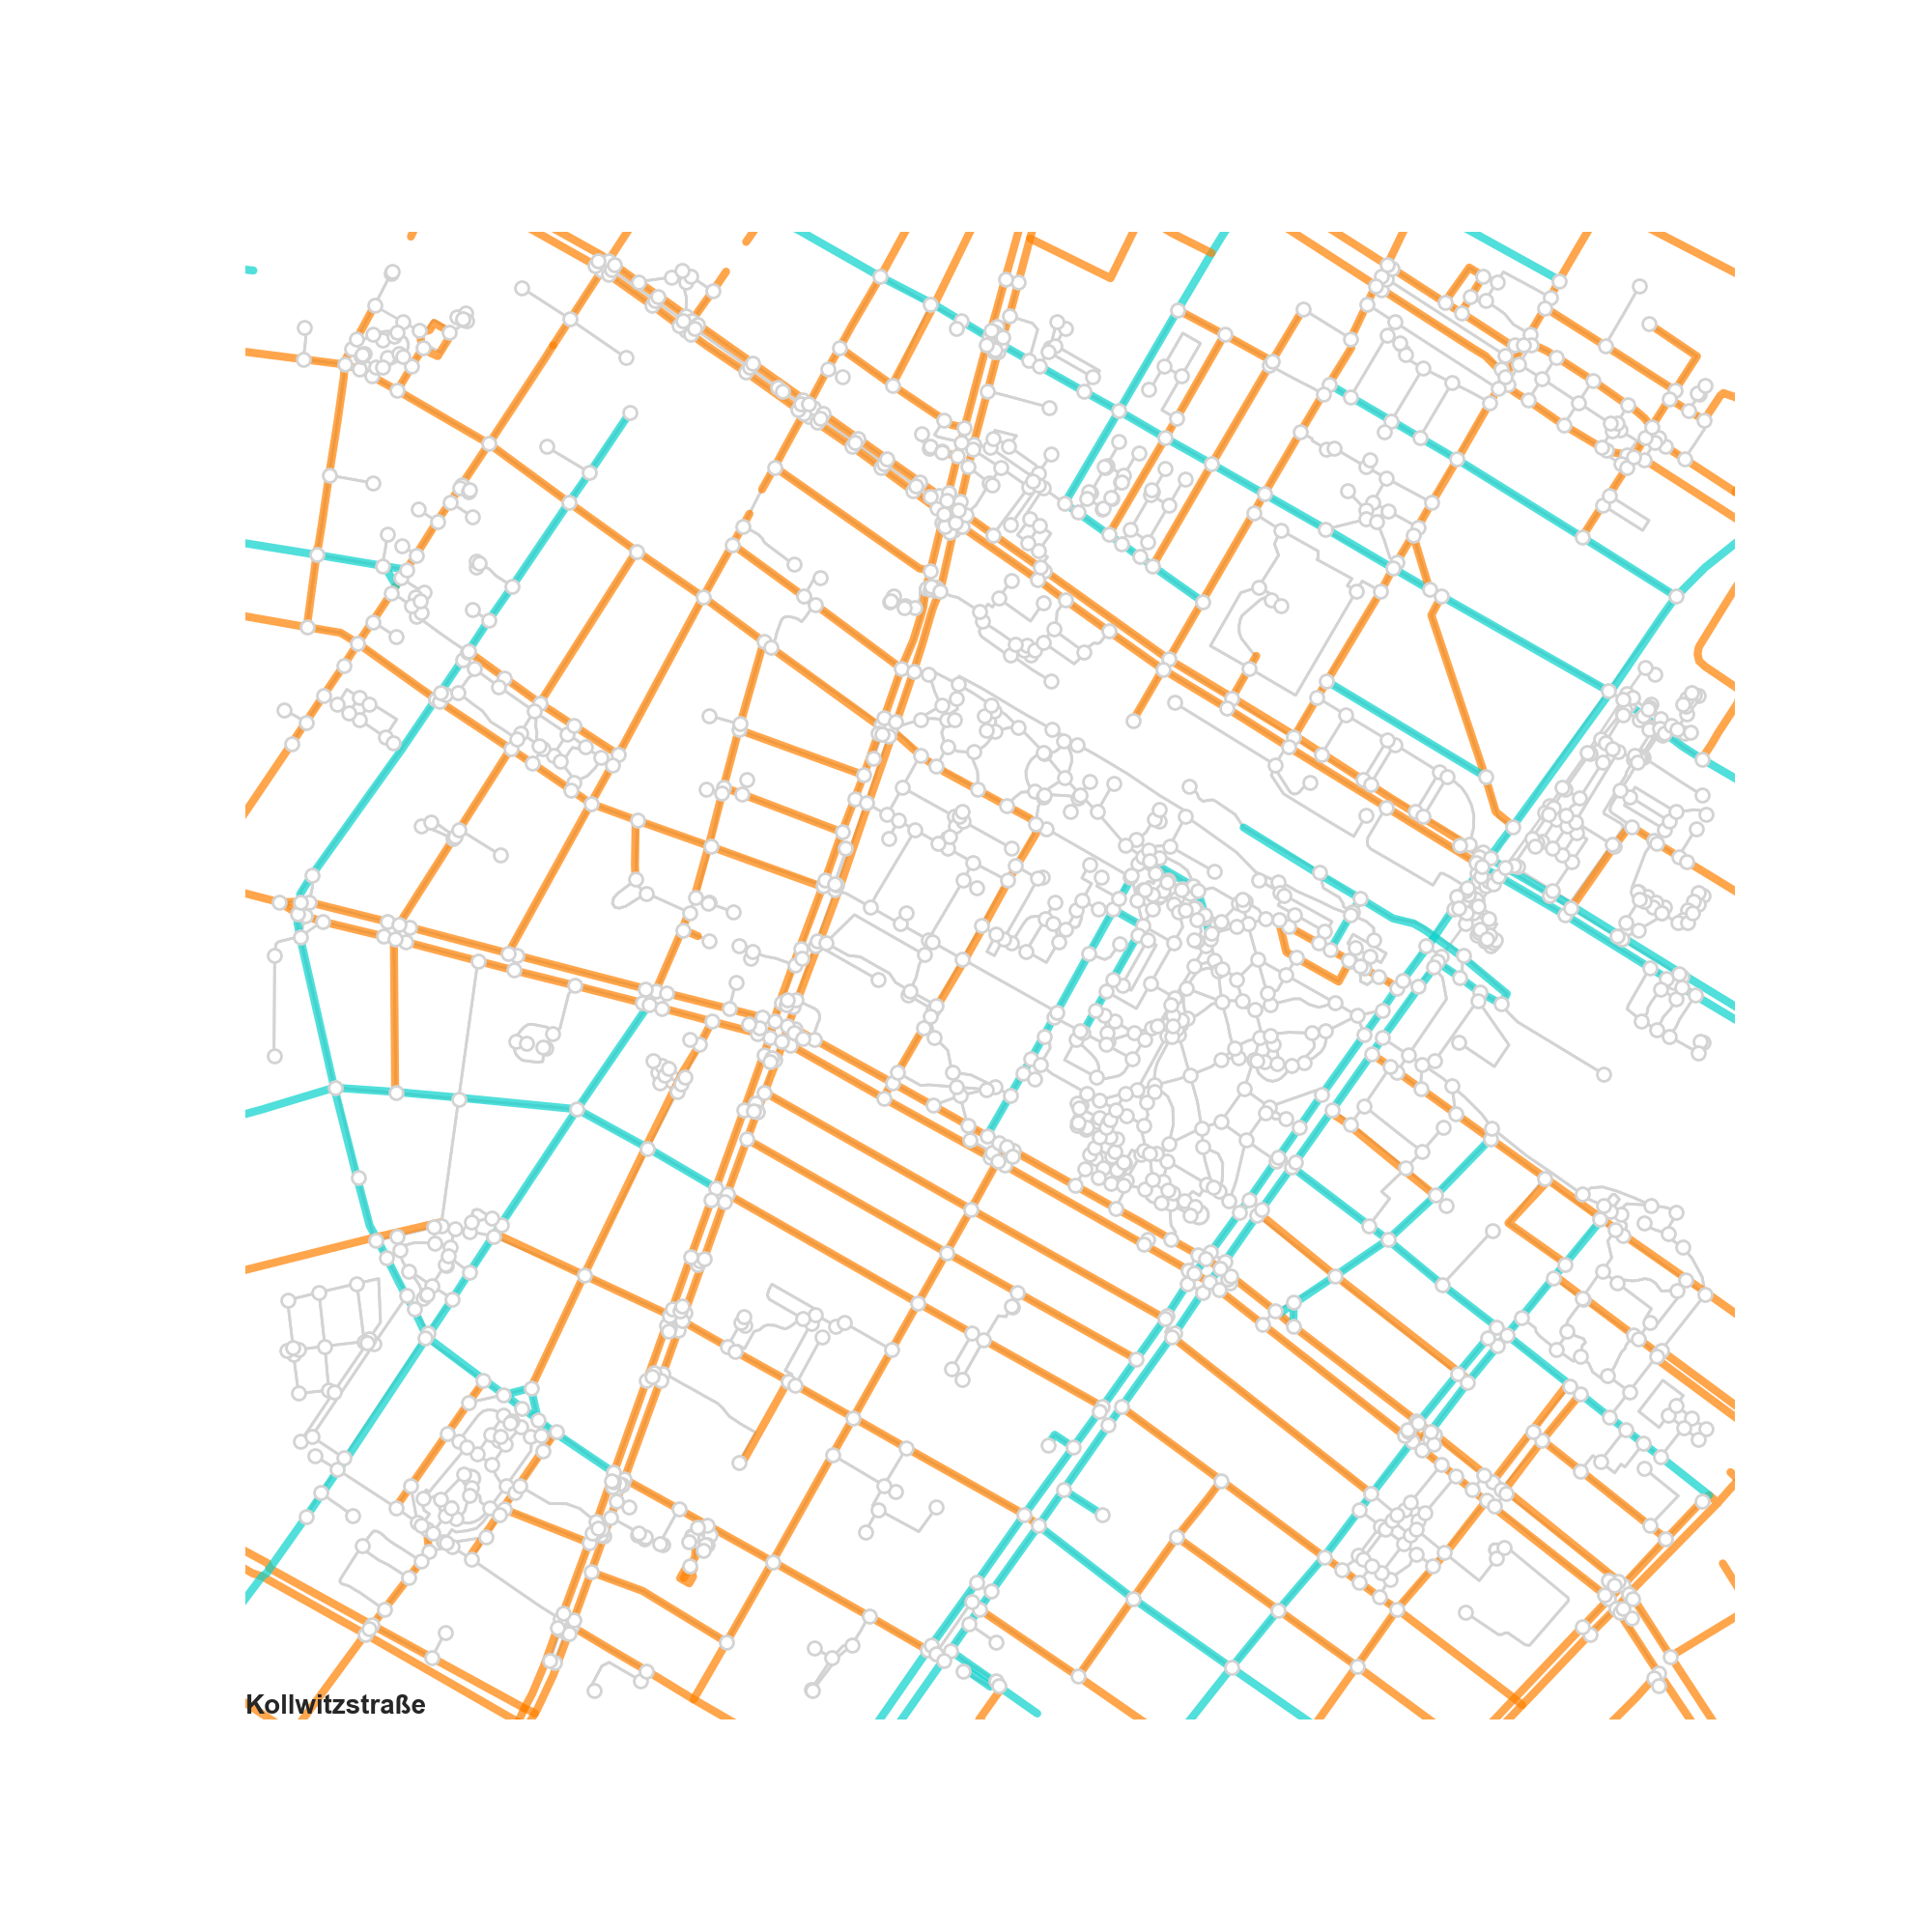

6

In [13]:
# Helpful-ish references:
# https://stackoverflow.com/questions/41125690/matplotlib-notebook-showing-a-blank-histogram
# https://stackoverflow.com/questions/43923313/canvas-mpl-connect-in-jupyter-notebook
# https://stackoverflow.com/questions/7908636/possible-to-make-labels-appear-when-hovering-over-a-point-in-matplotlib

%matplotlib notebook

G = ox.graph_from_address('Prenzlauer Berg, Berlin, Germany', distance=1000)
fig, ax = ox.plot_graph(G, fig_height=10, fig_width=10, show=False, close=False, edge_color='#D3D3D3',
                        # node_color='none)'
                        node_edgecolor='#D3D3D3', node_size=25, node_zorder=3, node_color='w')

text_x, _ = ax.get_xlim()
text_y, _ = ax.get_ylim()

text = ax.text(text_x, text_y, '', va='bottom', weight='bold')

plot_streets_within_axis(ax)

def on_plot_hover(event):
    for curve in ax.get_lines():
        if curve.contains(event)[0]:
            text.set_text(curve.get_gid())
            break

fig.canvas.mpl_connect('button_press_event', on_plot_hover)

In [41]:
decode_polyline.cache_info()

CacheInfo(hits=1, misses=313, maxsize=100000, currsize=313)